# 滋賀県の例に沿って同じようなことをしてみる

## 福岡県でやってみる

### 福岡県 医療機関GISデータ構造（JPGIS2.1／Shapefile対応）

[データ元リンク](https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-P04-v2_1.html)

| 属性名         | SHPカラム名 | 内容                                      | 備考                                |
|----------------|-------------|-------------------------------------------|-------------------------------------|
| 医療機関分類   | P04_001     | 病院 / 診療所 / 歯科診療所の区分         | コード化（例："1" = 病院）         |
| 施設名称       | P04_002     | 医療機関の名称（例：けご病院）           | 地図ラベル・識別用に使用可能       |
| 所在地         | P04_003     | 医療機関の所在地（住所）                 | 緯度経度はgeometryに格納されている |
| 診療科目1      | P04_004     | 主な診療科目                              | 長文の場合は次のカラムに続く       |
| 診療科目2      | P04_005     | 診療科目1が長すぎる場合の続き            |                                     |
| 診療科目3      | P04_006     | 診療科目2が長すぎる場合の続き            |                                     |
| 開設者分類     | P04_007     | 開設主体の分類（例：国立、公立、私立）   | 病院のみ対象。コードリストで管理   |
| geometry       | —           | 座標情報（POINT形式）                     | 緯度・経度情報（ネットワーク分析可） |

> ※ コード対応（医療機関分類・開設者分類など）はメタデータ付属のコードリスト参照

## 医療機関コードリスト（国土数値情報 P04）

### 医療機関分類コード（`P04_001`）

| コード | 医療機関分類     |
|:------:|------------------|
| 1      | 病院              |
| 2      | 診療所            |
| 3      | 歯科診療所        |

### 開設者分類コード（`P04_007`）

| コード | 開設者分類                 |
|:------:|----------------------------|
| 1      | 国                         |
| 2      | 公的医療機関               |
| 3      | 社会保険関係団体           |
| 4      | 医療法人                   |
| 5      | 個人                       |
| 6      | その他                     |
| 9      | ^[分類対象外（診療所・歯科診療所等）]({"attribution":{"attributableIndex":"0-1"}}) |

In [1]:
import osmnx as ox
import sklearn

print(ox.__version__)
print(sklearn.__version__)

2.0.3
1.7.0


In [2]:
import geopandas as gpd

# Shapefile形式の読み込み
gdf = gpd.read_file("../data/P04-14_40_GML/P04-14_40-g_MedicalInstitution.shp", encoding='shift_jis')

# 内容確認
print(gdf.columns)
gdf.head()

Index(['P04_001', 'P04_002', 'P04_003', 'P04_004', 'P04_005', 'P04_006',
       'P04_007', 'geometry'],
      dtype='object')


/Users/pretz/miniconda3/envs/ox-env/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: One or several characters couldn't be converted correctly from shift_jis to UTF-8.  This warning will not be emitted anymore
  return ogr_read(


,P04_001,P04_002,P04_003,P04_004,P04_005,P04_006,P04_007,geometry
0,1,けご病院,福岡県福岡市中央区警固１−１４−８,内科 呼吸器内科 呼吸器外科 胃腸内科 リハビリテーション科 外科 循環器内科 肛門外科,None,None,4,POINT (130.39328 33.58495)
1,1,博愛会病院,福岡県福岡市中央区笹丘１−２８−２５,内科 整形外科 消化器内科 乳腺外科 循環器内科 呼吸器内科 リハビリテーション科 リウマチ科,None,None,4,POINT (130.378 33.5636)
2,1,堤病院,福岡県福岡市中央区清川３−１７−１１,胃腸科 外科 整形外科 麻酔科 内科 脳神経外科,None,None,5,POINT (130.41253 33.57669)
3,1,石蔵病院,福岡県福岡市中央区赤坂３−２−１３,精神科,None,None,5,POINT (130.38603 33.58116)
4,1,秋本病院,福岡県福岡市中央区警固１−８−３,外科 整形外科 脳神経外科 放射線科 肛門科 胃腸科 内科 心臓血管外科,None,None,4,POINT (130.39509 33.58298)


In [3]:
# 医療機関分類コード変換
type_map = {"1": "病院", "2": "診療所", "3": "歯科診療所"}
gdf["医療機関分類"] = gdf["P04_001"].map(type_map)

# 診療科目統合
gdf["診療科目"] = gdf[["P04_004", "P04_005", "P04_006"]].fillna("").agg("".join, axis=1)

# 開設者分類コード変換
founder_map = {
    "1": "国", "2": "公的医療機関", "3": "社会保険関係団体", 
    "4": "医療法人", "5": "個人", "6": "その他", "9": "分類対象外"
}
gdf["開設者分類"] = gdf["P04_007"].map(founder_map)

In [9]:
# 例: 医療機関データのGeoDataFrame（gdf_medical）がある前提

# PCI施設フラグ付け（診療科目に「循環器内科」または「心臓血管外科」が含まれる場合）
gdf['is_pci'] = gdf['診療科目'].fillna('').apply(
    lambda x: any(keyword in x for keyword in ['循環器内科', '心臓血管外科'])
)

# 外来医科診療所の判定（診療所であり、かつ内科などが含まれる）
gdf['is_outpatient_clinic'] = gdf.apply(
    lambda row: (row['医療機関分類'] == '診療所') and ('内科' in (row['診療科目'] or '')),
    axis=1
)

# （必要なら）三次救急施設のフラグ：別CSVなどで管理し、名称でマージ
# gdf_medical['is_tertiary_emergency'] = gdf_medical['施設名称'].isin(emergency_hospitals_list)

In [4]:
import osmnx as ox
G = ox.graph_from_place("Fukuoka, Japan", network_type="drive")

In [5]:
import networkx as nx

# 分速（例：40km/h → 667m/min）
meters_per_minute = 1000 * 40 / 60
cutoff = 30 * meters_per_minute

# 病院だけ抽出して1つ選ぶ
hospitals = gdf[gdf["医療機関分類"] == "病院"]
point = hospitals.geometry.iloc[0]
nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)

# アクセス圏ノード取得
lengths = nx.single_source_dijkstra_path_length(G, nearest_node, cutoff=cutoff, weight="length")
reachable_nodes = list(lengths.keys())

In [ ]:
import osmnx as ox
import sklearn

print(ox.__version__)
print(sklearn.__version__)

In [6]:
import folium
import osmnx as ox

# ノードとエッジをGeoDataFrameに変換
nodes, edges = ox.graph_to_gdfs(G)

# 病院の位置（例：hospitals.geometry.iloc[0]）
origin_point = hospitals.geometry.iloc[0]

# Folium マップを作成（中心は病院）
m = folium.Map(location=[origin_point.y, origin_point.x], zoom_start=13)

# 病院の位置にマーカー
folium.Marker(
    location=[origin_point.y, origin_point.x],
    popup="病院",
    icon=folium.Icon(color='red', icon='plus-sign')
).add_to(m)

# 30分圏内のノードを青い円で描画
for node in reachable_nodes:
    node_geom = nodes.loc[node].geometry
    folium.CircleMarker(
        location=[node_geom.y, node_geom.x],
        radius=2,
        color="blue",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# 保存してブラウザで開けるように
m.save("../outputs/reachable_area_map.html")

In [10]:
# PCI施設だけを抽出
pci_gdf = gdf[gdf["is_pci"]]

# EPSG:4326 → Gの座標系に統一（例: G が未投影なら変換不要）
# pci_gdf = pci_gdf.to_crs(G.graph['crs'])  # osmnxで明示的にcrs指定した場合

In [13]:
import geopandas as gpd

# Shapefile を読み込み
n03_gdf = gpd.read_file("../data/N03-20240101_40_GML/N03-20240101_40.shp")

In [20]:
# OSMnxや人口メッシュと合わせる（例: WGS84）
fukuoka_boundary_gdf = n03_gdf.to_crs("EPSG:4326")
# 結合したポリゴン（複数市区町村を1つに）
fukuoka_polygon = fukuoka_boundary_gdf.unary_union

/var/folders/dc/pn28c_fx3596pw1n436t7vm40000gn/T/ipykernel_88876/521901901.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  fukuoka_polygon = fukuoka_boundary_gdf.unary_union


In [21]:
import osmnx as ox

# 道路ネットワーク（自動車移動用）を取得
G = ox.graph_from_polygon(fukuoka_polygon, network_type="drive")

# 速度・時間・距離を推定する
G = ox.add_edge_speeds(G)         # 推定速度（km/h）
G = ox.add_edge_travel_times(G)   # 推定移動時間（秒）
G = ox.add_edge_lengths(G)        # エッジ長さ（メートル）

AttributeError: module 'osmnx' has no attribute 'add_edge_lengths'

In [11]:
import networkx as nx
from shapely.geometry import MultiPoint
from geopandas import GeoDataFrame

def calculate_access_area_by_distance(G, facilities_gdf, cutoff=30000):
    polygons = []

    for idx, row in facilities_gdf.iterrows():
        point = row.geometry
        try:
            nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
            lengths = nx.single_source_dijkstra_path_length(G, nearest_node, cutoff=cutoff, weight='length')
            access_nodes = list(lengths.keys())

            access_points = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in access_nodes]
            mp = MultiPoint(access_points)
            polygon = mp.convex_hull
            polygons.append(polygon)

        except Exception as e:
            print(f"Error at index {idx}: {e}")
            continue

    return GeoDataFrame({'geometry': polygons}, crs="EPSG:4326")

/var/folders/dc/pn28c_fx3596pw1n436t7vm40000gn/T/ipykernel_88876/1843341918.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/dc/pn28c_fx3596pw1n436t7vm40000gn/T/ipykernel_88876/1843341918.py:19: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dc/pn28c_fx3596pw1n436t7vm40000gn/T/ipykernel_88876/1843341918.py:19: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dc/pn28c_fx3596pw1n436t7vm40000gn/T/ipykernel_88876/1843341918.py:19: UserWarning: Glyph 12475 (\N{KATAKANA LETTER SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/dc/pn28c_fx3596pw1n436t7vm40000gn/T/ipykernel_88876/1843341918.py:19: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font

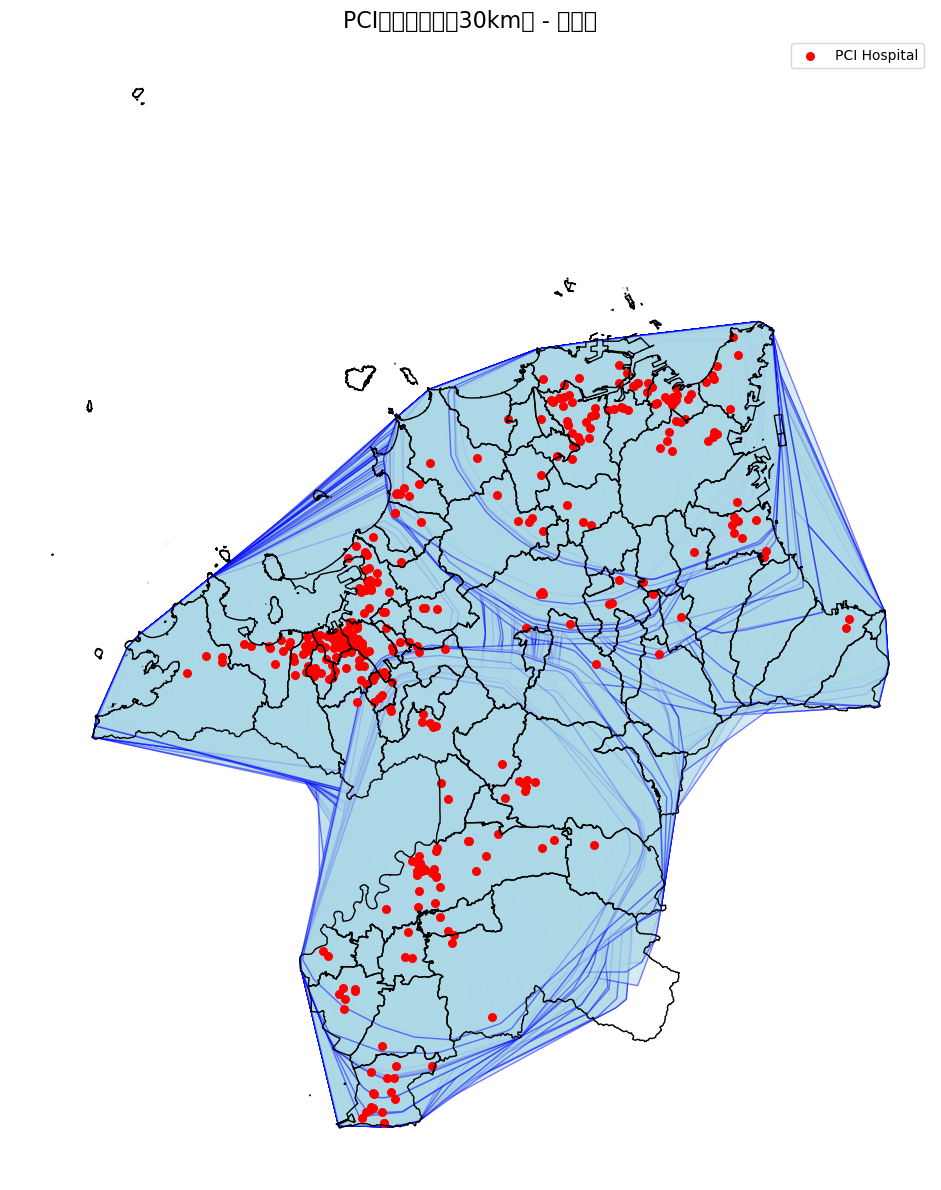

In [18]:
import matplotlib.pyplot as plt

# アクセス圏ポリゴン（GeoDataFrame）とPCI施設の位置（GeoDataFrame）を可視化
fig, ax = plt.subplots(figsize=(12, 12))

# アクセス圏を薄い青で表示
access_gdf.plot(ax=ax, color="lightblue", edgecolor="blue", alpha=0.5, label="30km Access Area")

# PCI病院を赤い点で表示
pci_gdf.plot(ax=ax, color="red", markersize=30, label="PCI Hospital")

# 福岡県境界（あれば）も追加するとより分かりやすい
fukuoka_boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black")

# タイトルなど
plt.title("PCIアクセス圏（30km） - 福岡県", fontsize=16)
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()